# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

1. Columns meaning
    * **Channel**: Horeca (Hotel/Restaurant/Cafe) or Retail channel. Values: [1, 2]
    * **Region**: Lisbon, Oporto or Other. Values: [1, 2, 3]
    * **Fresh**: Annual spending (m.u.) on fresh products. Continue.
    * **Milk**: Annual spending (m.u.) on milk products. Continue.
    * **Grocery**: Annual spending (m.u.) on grocery products. Continue.
    * **Frozen**: Annual spending (m.u.) on frozen products. Continue.
    * **Detergents_Paper**: Annual spending (m.u.) on detergents and paper products. Continue.
    * **Delicassen**: Annual spending (m.u.) on delicatessen products. Continue.

In [3]:
#customers["Channel"].value_counts() # Get values of Channel
#customers["Region"].value_counts() # Get values of Region

#customers.dtypes # all types are int64
customers.isnull().sum() # No null values

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

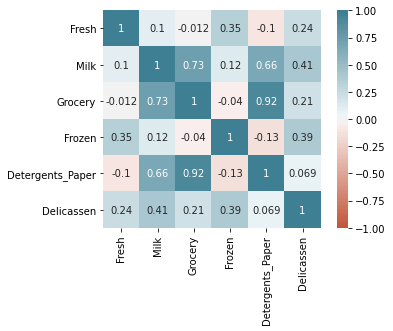

In [4]:
# Find possible high correlations between the continuous variables (Channel and Region are nominal)
df_cont = customers.drop(columns=["Channel", "Region"])
corr_cont = df_cont.corr()
ax = sns.heatmap( corr_cont, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot = True,
    square=True
)

# Conclusion: There is a high correlation between Milk-Detergents_Paper (0.66) and Milk-Grocery (0.73), 
# but the highest is between Grocery and Detergents_Paper (0.92)

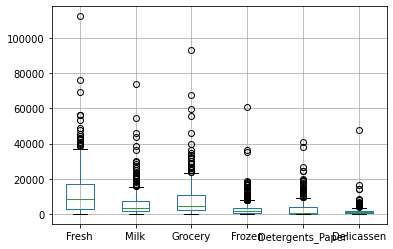

In [5]:
# Check outliers with boxplot
df_cont.boxplot(column = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen'])

# Conclusion: There are some outliers colored as black points

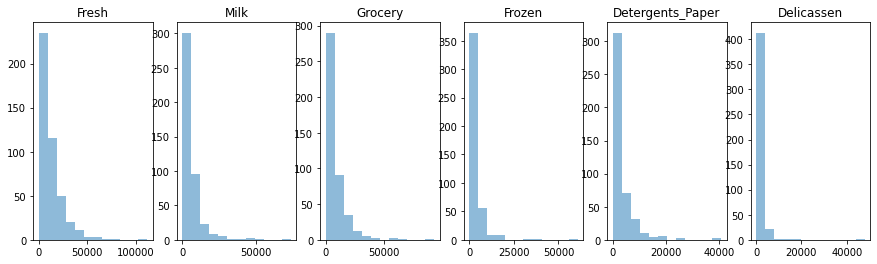

In [6]:
# Distribution
fig, ax = plt.subplots(1, 6, figsize = (15,4))
for i, col in enumerate(df_cont.columns):
    ax[i].hist(df_cont[col], bins=12, alpha=0.5)
    ax[i].set_title(col)

# Conclusion: All columns have an exponential distribution. They all have a positive skew as the right tail is
# longer than the left one

# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [7]:
# CORRELATION
# Although there is a high correlation between Grocery, Detergents_Paper and Milk, we are not going to delete
# any of them as there are few columns and correlation can be due to multiple factors.
# customers_clean = customers.drop(columns = "Grocery")

In [8]:
# IDENTIFICATION OF OUTLIERS
# A point is an outliers if it's greater than 1.5 times the 3rd quartile or 1.5 times less than the 1st 
# quartile.

# To identify the outliers, we'll calculate the IQR for the entire dataframe
Q1 = customers.quantile(0.25)
Q3 = customers.quantile(0.75)
IQR = Q3 - Q1

# This matrix shows only the outliers
#customers[((customers < (Q1 - 1.5 * IQR)) | (customers > (Q3 + 1.5 * IQR)))]

# Select the rows where all values are within the IQR
customers_clean = customers[~ ((customers < (Q1 - 1.5 * IQR)) | (customers > (Q3 + 1.5 * IQR))).any(axis=1)]
print (customers_clean.shape)
customers_clean = customers_clean.reset_index()
customers_clean.drop(columns = "index", inplace = True)

(332, 8)


In [9]:
customers_clean.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,1,3,13265,1196,4221,6404,507,1788
3,2,3,9413,8259,5126,666,1795,1451
4,2,3,12126,3199,6975,480,3140,545


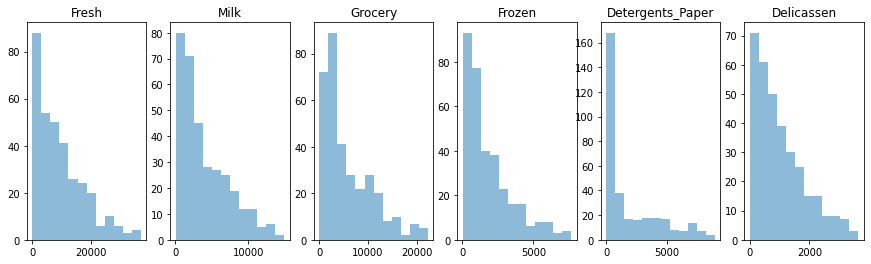

In [11]:
fig, ax = plt.subplots(1, 6, figsize = (15,4))
col_name = ["Fresh", "Milk", "Grocery", "Frozen", "Detergents_Paper", "Delicassen"]
for i, col in enumerate(col_name):
    ax[i].hist(customers_clean[col], bins=12, alpha=0.5)
    ax[i].set_title(col)
    
# Conclusion: It is still an exponential distribution but the scale has decreased    

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [12]:
# Scaling only continuous data, not Channel or Region
scaler = StandardScaler() # model
scaler = scaler.fit(customers_clean[col_name]) # model train
continuous_scaled = scaler.transform(customers_clean[col_name]) 


# Create a dataframe with the continuous data scaled
continuous_scaled_df = pd.DataFrame(data = continuous_scaled, 
                                 index = range(0, len(customers_clean)),
                                 columns = col_name)

# Add the Channel and Region columns
customers_scale = pd.concat([customers_clean[["Channel", "Region"]], continuous_scaled_df], axis = 1)
customers_scale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,0.383041,1.652898,0.334978,-0.967004,0.305053,0.390465
1,2,3,-0.305588,1.698756,0.733878,-0.059255,0.569139,0.922591
2,1,3,0.456174,-0.866283,-0.328862,2.662821,-0.619462,0.937169
3,2,3,-0.016491,1.236906,-0.148989,-0.701951,-0.069958,0.527749
4,2,3,0.316411,-0.269838,0.218508,-0.811022,0.503864,-0.572949


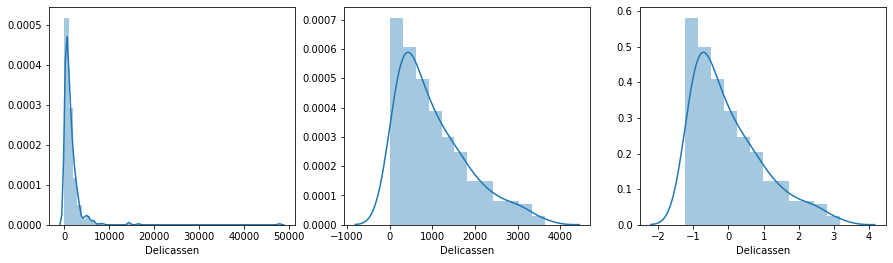

In [13]:
# FUNCIÓN StandardScaler()

fig, subs = plt.subplots(1, 3, figsize = (15,4))
sns.distplot(customers["Delicassen"], ax=subs[0])
sns.distplot(customers_clean["Delicassen"], ax=subs[1])
sns.distplot(continuous_scaled_df["Delicassen"], ax=subs[2])

# Gráfica 0: Datos originales, en el boxplot hemos visto outliers y no podemos entrenar el modelo con estos
# valores (p.ej, hay un pequeño repunte en Delicassen =50k)
# Gráfica 1: Quitamos los outliers (valores fuera del IQR)
# Gráfica 2: Estandarizamos los valores con una media=0 y una desv. estandar=1

# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [16]:
# K-MEANS model
# Agrupa los clientes minimizando la suma de distancias entre cada cliente y el centroide de su grupo o
# cluster.

In [20]:
model = KMeans() # K-Means model, by default n_clusters = 8 (por defecto, hará 8 grupos)
labels = model.fit(customers_scale).labels_ # train the model and get the clusters
#print(labels)
customers_scale["labels"] = labels # asigna a cada cliente un cluster

Count the values in `labels`.

In [21]:
customers_scale["labels"].value_counts() # Hay 8 clusters, y en cada uno de ellos, hay estos clientes

6    95
5    38
2    38
1    37
4    35
0    34
7    29
3    26
Name: labels, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [23]:
# DBSCAN
# Agrupa por densidad de datos; i.e. dos puntos son alcanzables si entre ellos hay una distancia máxima eps
# DBSCAN requiere dos parámetros: eps y el número mínimo de puntos requeridos para que una región se
# considere densa.

In [27]:
model = DBSCAN(eps=0.5) # model ponemos eps=0.5 porque las magnitudes están normalizadas. Si lo hiciéramos 
                        # con magnitudes absolutas (y sin outliers), sería eps entorno a 800-1000, acorde con
                        # las uds absolutas.
labels_DB = model.fit(customers_scale).labels_ #train
customers_scale["labels_DBSCAN"] = labels_DB

Count the values in `labels_DBSCAN`.

In [28]:
customers_scale["labels_DBSCAN"].value_counts()

-1    308
 0     24
Name: labels_DBSCAN, dtype: int64

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

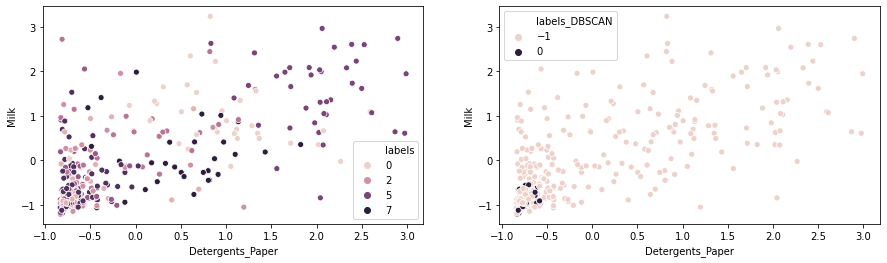

In [29]:
fig, subs = plt.subplots(1,2, figsize = (15, 4))
sns.scatterplot(x="Detergents_Paper", y="Milk", hue="labels",
                data=customers_scale, ax=subs[0])
sns.scatterplot(x="Detergents_Paper", y="Milk", hue="labels_DBSCAN",
                data=customers_scale, ax=subs[1])

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

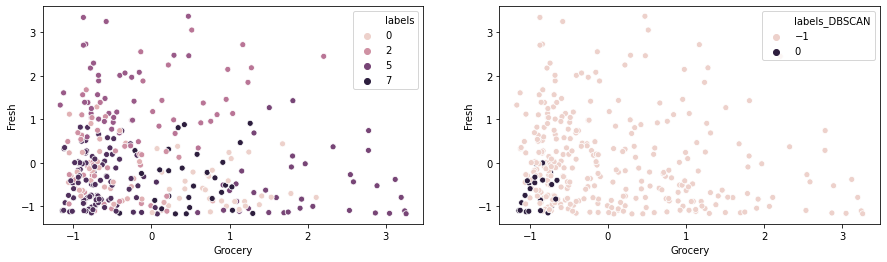

In [30]:
fig, subs = plt.subplots(1,2, figsize = (15, 4))
sns.scatterplot(x="Grocery", y="Fresh", hue="labels",
                data=customers_scale, ax=subs[0])
sns.scatterplot(x="Grocery", y="Fresh", hue="labels_DBSCAN",
                data=customers_scale, ax=subs[1])

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

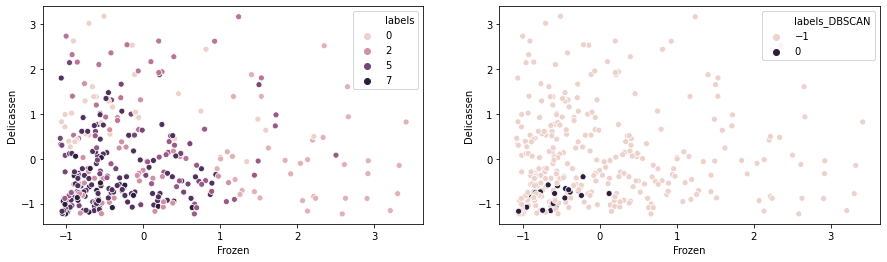

In [31]:
fig, subs = plt.subplots(1,2, figsize = (15, 4))
sns.scatterplot(x="Frozen", y="Delicassen", hue="labels",
                data=customers_scale, ax=subs[0])
sns.scatterplot(x="Frozen", y="Delicassen", hue="labels_DBSCAN",
                data=customers_scale, ax=subs[1])

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [33]:
customers_scale.groupby(["labels", "labels_DBSCAN"]).agg("mean")

Channel    Region     Fresh      Milk   Grocery  \
labels labels_DBSCAN                                                     
0      -1             1.823529  2.852941 -0.506083  0.962742  0.830332   
1      -1             1.027027  2.297297 -0.223328 -0.470354 -0.583251   
2      -1             1.000000  1.131579 -0.106820 -0.429141 -0.578074   
3      -1             1.461538  2.615385  1.476511  0.548243  0.440310   
4      -1             1.028571  2.685714  1.708884 -0.502827 -0.541569   
5      -1             1.921053  2.578947 -0.513010  1.546060  1.936875   
6      -1             1.014085  2.929577 -0.326403 -0.527121 -0.626797   
        0             1.000000  3.000000 -0.638414 -0.887623 -0.887188   
7      -1             1.586207  2.689655 -0.368282  0.148279  0.517811   

                        Frozen  Detergents_Paper  Delicassen  
labels labels_DBSCAN                                          
0      -1            -0.219118          0.916043    1.150027  
1      -1             2.060285         -0.549148   -0.048146  
2      -1            -0.206905         -0.525838   -0.330001  
3      -1            -0.158921          0.009166    1.711807  
4      -1             0.351377         -0.633906   -0.296022  
5      -1            -0.371977          2.035849   -0.011858  
6      -1            -0.305923         -0.619053   -0.207367  
        0            -0.595885         -0.737355   -0.835215  
7      -1            -0.652673          0.530698   -0.817478

**Which algorithm appears to perform better?**

* El K-Means agrupa en más clusters a los clientes que el DBSCANS (8 frente a 2). 
* Como estamos haciendo el K-Means con una dimensionalidad de 6, los clientes no tienen por qué distinguirse en clusters al plotearlos en 2D. Quizás si los ploteamos en más dimensiones, se puedan distinguir mejor.
* El DBSCAN hace sólo los clusters y está dimensionado para 6 variables, por lo que igualmente, necesitaríamos mirar otras dimensiones para distinguir mejor los grupos de clientes.

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

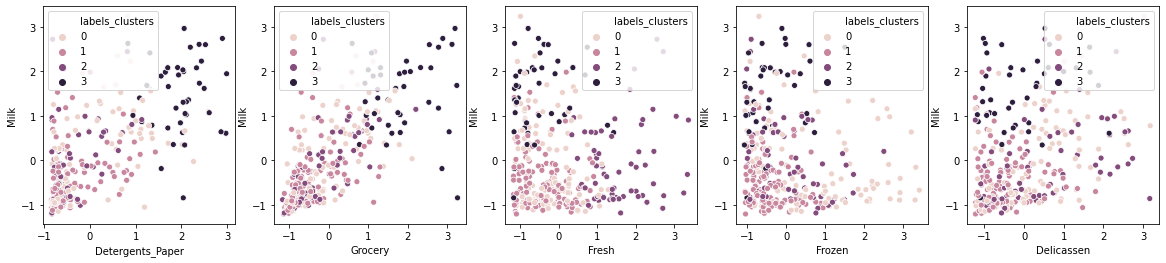

In [40]:
model = KMeans(n_clusters=4) # K-Means model
labels = model.fit(customers_scale).labels_ # train the model
customers_scale["labels_clusters"] = labels

fig, subs = plt.subplots(1,5, figsize = (20, 4))
sns.scatterplot(x="Detergents_Paper", y="Milk", hue="labels_clusters",
                data=customers_scale, ax=subs[0])
sns.scatterplot(x="Grocery", y="Milk", hue="labels_clusters",
                data=customers_scale, ax=subs[1])
sns.scatterplot(x="Fresh", y="Milk", hue="labels_clusters",
                data=customers_scale, ax=subs[2])
sns.scatterplot(x="Frozen", y="Milk", hue="labels_clusters",
                data=customers_scale, ax=subs[3])
sns.scatterplot(x="Delicassen", y="Milk", hue="labels_clusters",
                data=customers_scale, ax=subs[4])

# Aquí podríamos distinguir un tipo de cliente (perteneciente al cluster 3, coloreado en oscuro) que compra 
# mucho detergente, mucha grocery, pero poco alimento fresco, poco congelado y poca delicatessen

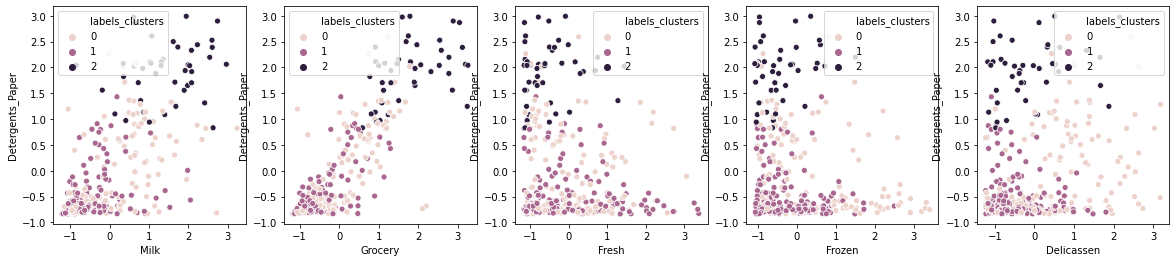

In [42]:
model = KMeans(n_clusters=3) # K-Means model
labels = model.fit(customers_scale).labels_ # train the model
customers_scale["labels_clusters"] = labels

fig, subs = plt.subplots(1,5, figsize = (20, 4))
sns.scatterplot(x="Milk", y="Detergents_Paper", hue="labels_clusters",
                data=customers_scale, ax=subs[0])
sns.scatterplot(x="Grocery", y="Detergents_Paper", hue="labels_clusters",
                data=customers_scale, ax=subs[1])
sns.scatterplot(x="Fresh", y="Detergents_Paper", hue="labels_clusters",
                data=customers_scale, ax=subs[2])
sns.scatterplot(x="Frozen", y="Detergents_Paper", hue="labels_clusters",
                data=customers_scale, ax=subs[3])
sns.scatterplot(x="Delicassen", y="Detergents_Paper", hue="labels_clusters",
                data=customers_scale, ax=subs[4])

# Aquí podríamos distinguir un tipo de cliente (perteneciente al cluster 3, coloreado en oscuro) que compra 
# mucho detergente, mucha grocery, pero poco alimento fresco, poco congelado y poca delicatessen

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

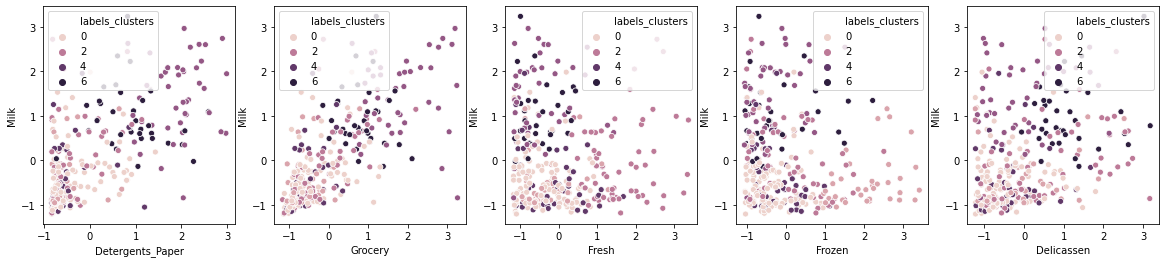

In [50]:
# eps: The maximum distance between two samples
# min_samples: number of samples (or total weight) in a neighborhood for a point to be considered as a core 
# point

model = DBSCAN(eps=0.8, min_samples=20) # model               
labels_DB = model.fit(customers_scale).labels_ #train
customers_scale["labels_DBSCAN_exp"] = labels_DB

fig, subs = plt.subplots(1,5, figsize = (20, 4))
sns.scatterplot(x="Detergents_Paper", y="Milk", hue="labels_clusters",
                data=customers_scale, ax=subs[0])
sns.scatterplot(x="Grocery", y="Milk", hue="labels_clusters",
                data=customers_scale, ax=subs[1])
sns.scatterplot(x="Fresh", y="Milk", hue="labels_clusters",
                data=customers_scale, ax=subs[2])
sns.scatterplot(x="Frozen", y="Milk", hue="labels_clusters",
                data=customers_scale, ax=subs[3])
sns.scatterplot(x="Delicassen", y="Milk", hue="labels_clusters",
                data=customers_scale, ax=subs[4])